Epoch 1: Train Loss = 0.6812, Val Loss = 0.6762
Epoch 2: Train Loss = 0.6336, Val Loss = 0.6871
Early stopping triggered.


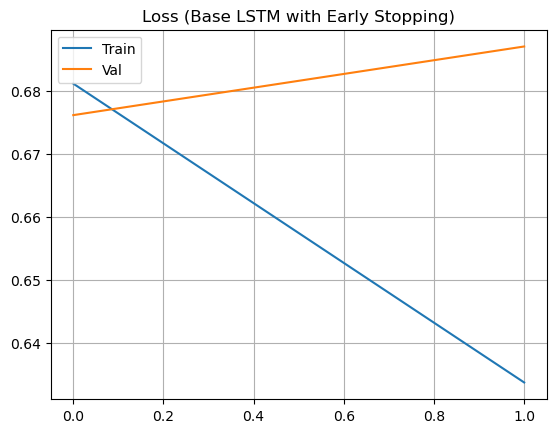

Validation Accuracy: 0.57


In [32]:
import re
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import pad_sequence

# Choose dataset: 'liar' or 'fakenews'
DATASET = 'liar'  # or 'fakenews'

if DATASET == 'liar':
    df = pd.read_csv("cleaned_liar_dataset.csv").dropna(subset=["clean_statement", "label"])
    X_text = df["clean_statement"].tolist()
elif DATASET == 'fakenews':
    df = pd.read_csv("cleaned_fakenews_df.csv").dropna(subset=["clean_title", "label"])
    X_text = df["clean_title"].tolist()
else:
    raise ValueError("Invalid DATASET option")

y = df["label"].tolist()

# Tokenization and vocab
def tokenize(text):
    return re.sub(r"[^\w\s]", "", text.lower()).split()

tokenized = [tokenize(text) for text in X_text]
counter = Counter(token for tokens in tokenized for token in tokens)
vocab = {"<pad>": 0, "<unk>": 1}
vocab.update({word: i + 2 for i, (word, _) in enumerate(counter.items())})

def encode(tokens, max_len=100):
    ids = [vocab.get(token, vocab["<unk>"]) for token in tokens]
    return ids[:max_len]

# Dataset
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = [torch.tensor(encode(tokenize(x))) for x in texts]
        self.labels = torch.tensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

def collate_fn(batch):
    texts, labels = zip(*batch)
    lengths = torch.tensor([len(text) for text in texts])
    texts = pad_sequence(texts, batch_first=True, padding_value=vocab["<pad>"])
    return texts, lengths, torch.tensor(labels)

# Split
X_train, X_val, y_train, y_val = train_test_split(X_text, y, test_size=0.2, random_state=0)
train_loader = DataLoader(TextDataset(X_train, y_train), batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(TextDataset(X_val, y_val), batch_size=32, shuffle=False, collate_fn=collate_fn)

# Model
class BaseLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim=100, hidden_dim=128):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 2)

    def forward(self, x, lengths):
        x = self.embed(x)
        packed = nn.utils.rnn.pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, (h, _) = self.lstm(packed)
        return self.fc(h[-1])

# EarlyStopping
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.best_model_state = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# Training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BaseLSTM(len(vocab)).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

train_losses = []
val_losses = []
early_stopper = EarlyStopping(patience=1)

for epoch in range(30):
    model.train()
    epoch_loss = 0
    for xb, lengths, yb in train_loader:
        xb, lengths, yb = xb.to(device), lengths.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb, lengths)
        loss = loss_fn(preds, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    train_losses.append(epoch_loss / len(train_loader))

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, lengths, yb in val_loader:
            xb, lengths, yb = xb.to(device), lengths.to(device), yb.to(device)
            preds = model(xb, lengths)
            val_loss += loss_fn(preds, yb).item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}: Train Loss = {train_losses[-1]:.4f}, Val Loss = {val_loss:.4f}")

    early_stopper(val_loss, model)
    if early_stopper.early_stop:
        print("Early stopping triggered.")
        break

model.load_state_dict(early_stopper.best_model_state)

# Plot loss
plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Val")
plt.legend()
plt.title("Loss (Base LSTM with Early Stopping)")
plt.grid()
plt.show()

# Evaluate
model.eval()
correct = total = 0
with torch.no_grad():
    for xb, lengths, yb in val_loader:
        xb, lengths, yb = xb.to(device), lengths.to(device), yb.to(device)
        preds = model(xb, lengths).argmax(1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)

print(f"Validation Accuracy: {correct / total:.2f}")

Epoch 1: Train Loss = 0.4723, Val Loss = 0.4256
Epoch 2: Train Loss = 0.3602, Val Loss = 0.4070
Epoch 3: Train Loss = 0.2737, Val Loss = 0.4127
Early stopping triggered.


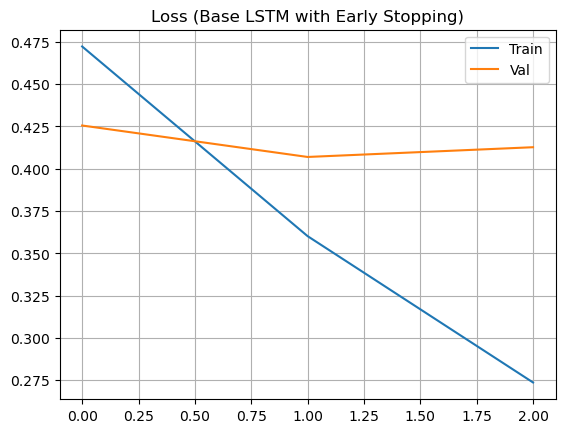

Validation Accuracy: 0.83


In [31]:
import re
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import pad_sequence

# Choose dataset: 'liar' or 'fakenews'
DATASET = 'fakenews'  # or 'fakenews'

if DATASET == 'liar':
    df = pd.read_csv("cleaned_liar_dataset.csv").dropna(subset=["clean_statement", "label"])
    X_text = df["clean_statement"].tolist()
elif DATASET == 'fakenews':
    df = pd.read_csv("cleaned_fakenews_df.csv").dropna(subset=["clean_title", "label"])
    X_text = df["clean_title"].tolist()
else:
    raise ValueError("Invalid DATASET option")

y = df["label"].tolist()

# Tokenization and vocab
def tokenize(text):
    return re.sub(r"[^\w\s]", "", text.lower()).split()

tokenized = [tokenize(text) for text in X_text]
counter = Counter(token for tokens in tokenized for token in tokens)
vocab = {"<pad>": 0, "<unk>": 1}
vocab.update({word: i + 2 for i, (word, _) in enumerate(counter.items())})

def encode(tokens, max_len=100):
    ids = [vocab.get(token, vocab["<unk>"]) for token in tokens]
    return ids[:max_len]

# Dataset
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = [torch.tensor(encode(tokenize(x))) for x in texts]
        self.labels = torch.tensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

def collate_fn(batch):
    texts, labels = zip(*batch)
    lengths = torch.tensor([len(text) for text in texts])
    texts = pad_sequence(texts, batch_first=True, padding_value=vocab["<pad>"])
    return texts, lengths, torch.tensor(labels)

# Split
X_train, X_val, y_train, y_val = train_test_split(X_text, y, test_size=0.2, random_state=0)
train_loader = DataLoader(TextDataset(X_train, y_train), batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(TextDataset(X_val, y_val), batch_size=32, shuffle=False, collate_fn=collate_fn)

# Model
class BaseLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim=100, hidden_dim=128):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 2)

    def forward(self, x, lengths):
        x = self.embed(x)
        packed = nn.utils.rnn.pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, (h, _) = self.lstm(packed)
        return self.fc(h[-1])

# EarlyStopping
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.best_model_state = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# Training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BaseLSTM(len(vocab)).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

train_losses = []
val_losses = []
early_stopper = EarlyStopping(patience=1)

for epoch in range(30):
    model.train()
    epoch_loss = 0
    for xb, lengths, yb in train_loader:
        xb, lengths, yb = xb.to(device), lengths.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb, lengths)
        loss = loss_fn(preds, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    train_losses.append(epoch_loss / len(train_loader))

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, lengths, yb in val_loader:
            xb, lengths, yb = xb.to(device), lengths.to(device), yb.to(device)
            preds = model(xb, lengths)
            val_loss += loss_fn(preds, yb).item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}: Train Loss = {train_losses[-1]:.4f}, Val Loss = {val_loss:.4f}")

    early_stopper(val_loss, model)
    if early_stopper.early_stop:
        print("Early stopping triggered.")
        break

model.load_state_dict(early_stopper.best_model_state)

# Plot loss
plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Val")
plt.legend()
plt.title("Loss (Base LSTM with Early Stopping)")
plt.grid()
plt.show()

# Evaluate
model.eval()
correct = total = 0
with torch.no_grad():
    for xb, lengths, yb in val_loader:
        xb, lengths, yb = xb.to(device), lengths.to(device), yb.to(device)
        preds = model(xb, lengths).argmax(1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)

print(f"Validation Accuracy: {correct / total:.2f}")

Epoch 1: Train Loss = 0.6731, Val Loss = 0.6416
Epoch 2: Train Loss = 0.6397, Val Loss = 0.6399
Epoch 3: Train Loss = 0.5954, Val Loss = 0.6609
Early stopping triggered.


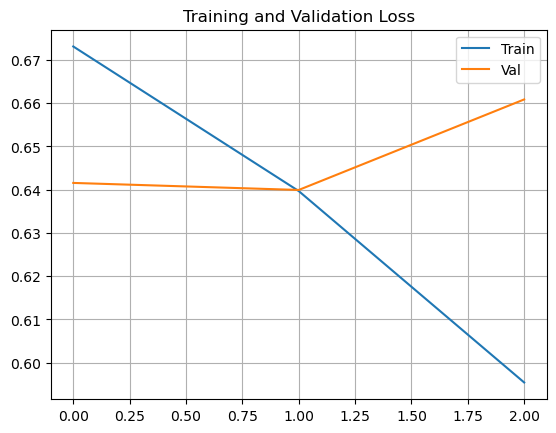

Validation Accuracy: 0.64


In [33]:
import re
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.nn.utils.rnn import pad_sequence

# Load dataset
df = pd.read_csv("cleaned_liar_dataset.csv").dropna(
    subset=["clean_statement", "label", "job_title", "clean_context"]
)

X_text, y = df["clean_statement"].tolist(), df["label"].tolist()

# Encode metadata
job_encoder = LabelEncoder()
df["job_encoded"] = job_encoder.fit_transform(df["job_title"])

party_cols = [col for col in df.columns if col.startswith("party_")]
party_labels = df[party_cols].idxmax(axis=1).str.replace("party_", "")
party_encoder = LabelEncoder()
df["party_encoded"] = party_encoder.fit_transform(party_labels)

context_encoder = LabelEncoder()
df["context_encoded"] = context_encoder.fit_transform(df["clean_context"])

X_job = df["job_encoded"].tolist()
X_party = df["party_encoded"].tolist()
X_context = df["context_encoded"].tolist()

# Tokenization and vocab
def tokenize(text):
    return re.sub(r"[^\w\s]", "", text.lower()).split()

tokenized = [tokenize(text) for text in X_text]
counter = Counter(token for tokens in tokenized for token in tokens)
vocab = {"<pad>": 0, "<unk>": 1}
vocab.update({word: i + 2 for i, (word, _) in enumerate(counter.items())})

def encode(tokens, max_len=100):
    ids = [vocab.get(token, vocab["<unk>"]) for token in tokens]
    return ids[:max_len]

def load_glove(path, vocab, embed_dim=100):
    embeddings = np.random.normal(scale=0.6, size=(len(vocab), embed_dim))
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.rstrip().split(' ')
            word = parts[0]
            vector = np.asarray(parts[1:], dtype='float32')
            if word in vocab:
                embeddings[vocab[word]] = vector
    return torch.tensor(embeddings, dtype=torch.float32)

# Dataset
class HybridLIARDataset(Dataset):
    def __init__(self, texts, jobs, parties, contexts, labels):
        self.texts = [torch.tensor(encode(tokenize(x))) for x in texts]
        self.jobs = torch.tensor(jobs)
        self.parties = torch.tensor(parties)
        self.contexts = torch.tensor(contexts)
        self.labels = torch.tensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.texts[idx], self.jobs[idx], self.parties[idx], self.contexts[idx], self.labels[idx]

def collate_fn(batch):
    texts, jobs, parties, contexts, labels = zip(*batch)
    lengths = torch.tensor([len(text) for text in texts])
    texts = pad_sequence(texts, batch_first=True, padding_value=vocab["<pad>"])
    return texts, lengths, torch.tensor(jobs), torch.tensor(parties), torch.tensor(contexts), torch.tensor(labels)

# Split
X_train, X_val, job_train, job_val, party_train, party_val, context_train, context_val, y_train, y_val = train_test_split(
    X_text, X_job, X_party, X_context, y, test_size=0.2, random_state=0)

train_loader = DataLoader(HybridLIARDataset(X_train, job_train, party_train, context_train, y_train),
                          batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(HybridLIARDataset(X_val, job_val, party_val, context_val, y_val),
                        batch_size=32, shuffle=False, collate_fn=collate_fn)

# Attention
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.attn = nn.Linear(hidden_dim * 2, 1)

    def forward(self, lstm_out, lengths):
        scores = self.attn(lstm_out).squeeze(-1)
        mask = torch.arange(lstm_out.size(1)).unsqueeze(0) >= lengths.unsqueeze(1)
        mask = mask.to(lstm_out.device)
        scores = scores.masked_fill(mask, -1e9)
        weights = torch.softmax(scores, dim=1)
        context = torch.bmm(weights.unsqueeze(1), lstm_out).squeeze(1)
        return context

# Model
class LSTMWithMetadataAttention(nn.Module):
    def __init__(self, vocab_size, job_size, party_size, context_size, embed_matrix, embed_dim=100, hidden_dim=128):
        super().__init__()
        self.embed_text = nn.Embedding.from_pretrained(embed_matrix, freeze=False, padding_idx=0)
        self.embed_job = nn.Embedding(job_size, 16)
        self.embed_party = nn.Embedding(party_size, 8)
        self.embed_context = nn.Embedding(context_size, 8)

        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.attention = Attention(hidden_dim)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_dim * 2 + 16 + 8 + 8, 2)

    def forward(self, x, lengths, job_id, party_id, context_id):
        x = self.embed_text(x)
        packed = nn.utils.rnn.pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        out, _ = self.lstm(packed)
        out, _ = nn.utils.rnn.pad_packed_sequence(out, batch_first=True)
        text_feat = self.attention(out, lengths)
        job_embed = self.embed_job(job_id)
        party_embed = self.embed_party(party_id)
        context_embed = self.embed_context(context_id)
        combined = torch.cat([text_feat, job_embed, party_embed, context_embed], dim=1)
        return self.fc(self.dropout(combined))

# Early Stopping
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.best_model_state = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# Train
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embed_matrix = load_glove("glove.6B.100d.txt", vocab)

model = LSTMWithMetadataAttention(
    vocab_size=len(vocab),
    job_size=df["job_encoded"].nunique(),
    party_size=df["party_encoded"].nunique(),
    context_size=df["context_encoded"].nunique(),
    embed_matrix=embed_matrix
).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

train_losses = []
val_losses = []
early_stopper = EarlyStopping(patience=1)

for epoch in range(30):
    model.train()
    epoch_loss = 0
    for xb, lengths, job, party, context, yb in train_loader:
        xb, lengths, job, party, context, yb = xb.to(device), lengths.to(device), job.to(device), party.to(device), context.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb, lengths, job, party, context)
        loss = loss_fn(preds, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    train_losses.append(epoch_loss / len(train_loader))

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, lengths, job, party, context, yb in val_loader:
            xb, lengths, job, party, context, yb = xb.to(device), lengths.to(device), job.to(device), party.to(device), context.to(device), yb.to(device)
            preds = model(xb, lengths, job, party, context)
            val_loss += loss_fn(preds, yb).item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}: Train Loss = {train_losses[-1]:.4f}, Val Loss = {val_loss:.4f}")

    early_stopper(val_loss, model)
    if early_stopper.early_stop:
        print("Early stopping triggered.")
        break

model.load_state_dict(early_stopper.best_model_state)

# Plot Loss
plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Val")
plt.legend()
plt.title('Training and Validation Loss')
plt.grid()
plt.show()

# Evaluate
model.eval()
correct = total = 0
with torch.no_grad():
    for xb, lengths, job, party, context, yb in val_loader:
        xb, lengths, job, party, context, yb = xb.to(device), lengths.to(device), job.to(device), party.to(device), context.to(device), yb.to(device)
        preds = model(xb, lengths, job, party, context).argmax(1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)

print(f"Validation Accuracy: {correct / total:.2f}")

Epoch 1: Train Loss = 0.4364, Val Loss = 0.3899
Epoch 2: Train Loss = 0.3275, Val Loss = 0.3691
Epoch 3: Train Loss = 0.2524, Val Loss = 0.3877
Early stopping triggered.


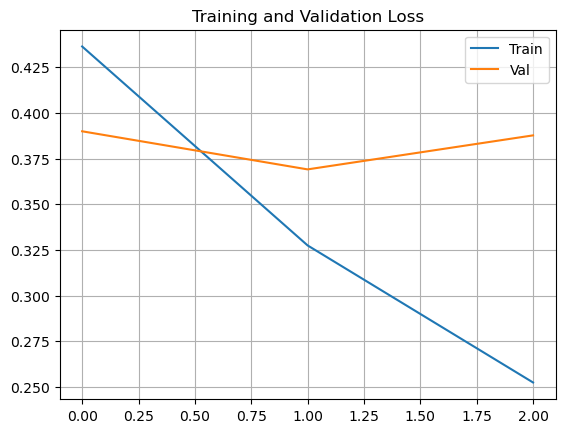

Validation Accuracy: 0.84


In [34]:
import re
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import pad_sequence

df = pd.read_csv("cleaned_fakenews_df.csv").dropna(subset=["clean_title", "label"])
X_text = df["clean_title"].tolist()
y = df["label"].tolist()

def tokenize(text):
    return re.sub(r"[^\w\s]", "", text.lower()).split()

tokenized = [tokenize(text) for text in X_text]
counter = Counter(token for tokens in tokenized for token in tokens)
vocab = {"<pad>": 0, "<unk>": 1}
vocab.update({word: i + 2 for i, (word, _) in enumerate(counter.items())})

def encode(tokens, max_len=100):
    ids = [vocab.get(token, vocab["<unk>"]) for token in tokens]
    return ids[:max_len]

def load_glove(path, vocab, embed_dim=100):
    embeddings = np.random.normal(scale=0.6, size=(len(vocab), embed_dim))
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.rstrip().split(' ')
            word = parts[0]
            vector = np.asarray(parts[1:], dtype='float32')
            if word in vocab:
                embeddings[vocab[word]] = vector
    return torch.tensor(embeddings, dtype=torch.float32)

class FakeNewsDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = [torch.tensor(encode(tokenize(x))) for x in texts]
        self.labels = torch.tensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

def collate_fn(batch):
    texts, labels = zip(*batch)
    lengths = torch.tensor([len(text) for text in texts])
    texts = pad_sequence(texts, batch_first=True, padding_value=vocab["<pad>"])
    return texts, lengths, torch.tensor(labels)

X_train, X_val, y_train, y_val = train_test_split(X_text, y, test_size=0.2, random_state=0)

train_loader = DataLoader(FakeNewsDataset(X_train, y_train), batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(FakeNewsDataset(X_val, y_val), batch_size=32, shuffle=False, collate_fn=collate_fn)

class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.attn = nn.Linear(hidden_dim * 2, 1)

    def forward(self, lstm_out, lengths):
        scores = self.attn(lstm_out).squeeze(-1)
        mask = torch.arange(lstm_out.size(1)).unsqueeze(0) >= lengths.unsqueeze(1)
        mask = mask.to(lstm_out.device)
        scores = scores.masked_fill(mask, -1e9)
        weights = torch.softmax(scores, dim=1)
        context = torch.bmm(weights.unsqueeze(1), lstm_out).squeeze(1)
        return context

class LSTMWithAttention(nn.Module):
    def __init__(self, vocab_size, embed_matrix, embed_dim=100, hidden_dim=128):
        super().__init__()
        self.embed_text = nn.Embedding.from_pretrained(embed_matrix, freeze=False, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.attention = Attention(hidden_dim)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_dim * 2, 2)

    def forward(self, x, lengths):
        x = self.embed_text(x)
        packed = nn.utils.rnn.pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        out, _ = self.lstm(packed)
        out, _ = nn.utils.rnn.pad_packed_sequence(out, batch_first=True)
        text_feat = self.attention(out, lengths)
        return self.fc(self.dropout(text_feat))

class EarlyStopping:
    def __init__(self, patience=3, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.best_model_state = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embed_matrix = load_glove("glove.6B.100d.txt", vocab)

model = LSTMWithAttention(len(vocab), embed_matrix).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

train_losses = []
val_losses = []
early_stopper = EarlyStopping(patience=1)

for epoch in range(30):
    model.train()
    epoch_loss = 0
    for xb, lengths, yb in train_loader:
        xb, lengths, yb = xb.to(device), lengths.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb, lengths)
        loss = loss_fn(preds, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    train_losses.append(epoch_loss / len(train_loader))

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, lengths, yb in val_loader:
            xb, lengths, yb = xb.to(device), lengths.to(device), yb.to(device)
            preds = model(xb, lengths)
            val_loss += loss_fn(preds, yb).item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}: Train Loss = {train_losses[-1]:.4f}, Val Loss = {val_loss:.4f}")

    early_stopper(val_loss, model)
    if early_stopper.early_stop:
        print("Early stopping triggered.")
        break

model.load_state_dict(early_stopper.best_model_state)

plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Val")
plt.legend()
plt.title('Training and Validation Loss')
plt.grid()
plt.show()

# Evaluate
model.eval()
correct = total = 0
with torch.no_grad():
    for xb, lengths, yb in val_loader:
        xb, lengths, yb = xb.to(device), lengths.to(device), yb.to(device)
        preds = model(xb, lengths).argmax(1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)

print(f"Validation Accuracy: {correct / total:.2f}")